# Autoencoders para la detección de anomalías cardiacas 

## 1- El problema a resolver

Detectar la presencia (sujeto *anormal*) o ausencia (sujeto *normal*) de irregularidades en el ritmo cardiaco, a partir de señales electrocardiográficas (ECG):

![](https://drive.google.com/uc?export=view&id=1pzydaNRbcSh1E-S4Ebh0jJEqsim6DeM9)

El problema es que usualmente se cuenta con sets de datos **desbalanceados** con más datos normales que anormales.


## 2 El set de datos

Se usará el set [ECG5000](https://timeseriesclassification.com/description.php?Dataset=ECG5000) con 7600 datos de entrenamiento y 1900 de prueba.

Cada dato contiene un ciclo cardiaco con 140 muestras, y que puede pertenecer a una de 5 categorías:

1. Normal
2. Anormal: contracción ventricular prematura
3. Anormal: contracción supra-ventricular prematura
4. Anormal: latido ectópico
5. Anormal pero patología desconocida

![](https://drive.google.com/uc?export=view&id=1x_sUD1rbM4MM4--s9D4wacRIWEo8aAzL)


## 3- Autoencoders y detección de anomalías

El problema del set ECG5000 es que contiene 4427 datos normales y 3173 anormales, es decir está desbalanceado.

De hecho para ciertas categorías anormales (2 a 4) se tienen muy pocos datos:

| Categoría   | Nro. datos |
|-------------|------------|
| 1 (normal)  | 4427       |
| 2 (anormal) | 2683       |
| 3 (anormal) | 149        |
| 4 (anormal) | 306        |
| 5 (anormal) | 35         |

Así que en lugar de un modelo de clasificación convencional (como una Red Neuronal) se usará un Autoencoder:

![](https://drive.google.com/uc?export=view&id=1LnoIDmfctQr5wmJaojFrZEA1ygPynylu)

El autoencoder se entrenará **únicamente con datos normales**. Así, al reconstruir un dato anormal **el error será alto**.

## 4- Implementación

### 4.1. Preparación de Google Drive y lectura de los sets de entrenamiento y prueba

In [1]:
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import wandb

wandb.init(project="keras-intro")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fcarazo (deepsf). Use `wandb login --relogin` to force relogin


In [3]:
keras.__version__

'3.0.5'

In [4]:
# from google.colab import drive
# drive.mount('/gdrive')

In [5]:
ruta = '/gdrive/MyDrive/videos/2021-06-25/'
ruta = ''

df_train = pd.read_csv(ruta + 'ECG5000_train.csv')
df_test = pd.read_csv(ruta + 'ECG5000_test.csv')

In [6]:
print(df_train.shape)
print(df_test.shape)

(7600, 141)
(1900, 141)


In [7]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-1.30300,-0.83573,-1.9336,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,...,-1.45820,-1.6676,-1.5977,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.08120,-2.82880
1,2,0.32288,-0.87847,-1.8023,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,...,-1.23050,-1.7218,-2.1953,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.23670,0.82832
2,2,1.39340,1.59260,1.2420,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,...,-1.90850,-2.5295,-3.0614,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.42200,-1.07370
3,1,-3.52270,-5.02610,-4.3613,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,...,0.83038,1.0084,1.1830,0.94636,0.952130,0.79343,0.84741,1.01390,0.31234,-2.19060
4,1,-1.91820,-3.22510,-3.4652,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,...,1.77690,1.5029,1.1651,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.14284,-0.66844


In [8]:
df_train['0'].value_counts()

0
1    4427
2    2683
4     306
3     149
5      35
Name: count, dtype: int64

### 4.2. Sets de entrenamiento y validación

In [9]:
# Pandas a arreglos numpy
datos_train = df_train.values
datos_test = df_test.values

# Etiquetas
cat_train = datos_train[:,0]
cat_test = datos_test[:,0]

# Subdivisión por categorías
x_train_1 = datos_train[cat_train==1,1:]
x_train_2 = datos_train[cat_train==2,1:]
x_train_3 = datos_train[cat_train==3,1:]
x_train_4 = datos_train[cat_train==4,1:]
x_train_5 = datos_train[cat_train==5,1:]

x_test_1 = datos_test[cat_test==1,1:]
x_test_2 = datos_test[cat_test==2,1:]
x_test_3 = datos_test[cat_test==3,1:]
x_test_4 = datos_test[cat_test==4,1:]
x_test_5 = datos_test[cat_test==5,1:]

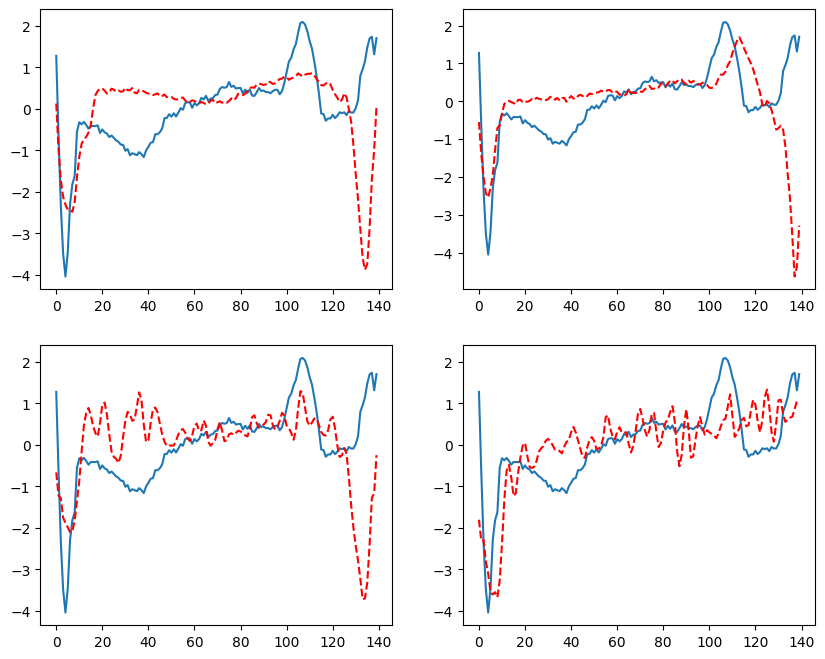

In [10]:
# Dibujar un dato normal y uno de cada anormal


ind = 10
normal = x_train_1[ind]
anormal_2 = x_train_2[ind]
anormal_3 = x_train_3[ind]
anormal_4 = x_train_4[ind]
anormal_5 = x_train_5[ind]

plt.figure(figsize=(10,8))
# plt.grid()
plt.subplot(2,2,1)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_2, 'r--')
plt.subplot(2,2,2)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_3, 'r--')
plt.subplot(2,2,3)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_4, 'r--')
plt.subplot(2,2,4)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_5, 'r--')
plt.show()

### 4.3. Preprocesamiento (normalización)

In [11]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

# Entrenar el escalador con los datos de x_train_1
x_train_1_s = min_max_scaler.fit_transform(x_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(x_train_1), np.max(x_train_1)))
print('Mínimo y máximo normalización: {:.1f}, {:.1f}'.format(np.min(x_train_1_s), np.max(x_train_1_s)))

# Escalar los datos de x_test_1, x_test_2, x_test_3, x_test_4, x_test_5
x_test_1_s = min_max_scaler.transform(x_test_1)
x_test_2_s = min_max_scaler.transform(x_test_2)
x_test_3_s = min_max_scaler.transform(x_test_3)
x_test_4_s = min_max_scaler.transform(x_test_4)
x_test_5_s = min_max_scaler.transform(x_test_5)

Mínimo y máximo originales: -7.1, 5.0
Mínimo y máximo normalización: 0.0, 1.0


### 4.4. Creación del Autoencoder en TensorFlow/Keras

In [12]:
140*32+32

4512

In [13]:
from keras.backend import clear_session
clear_session()

In [17]:
import random
import numpy as np
import tensorflow as tf
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

# Simple Keras Model

# Launch 5 experiments, trying different dropout rates
for run in range(3):
    # Start a run, tracking hyperparameters
    
    for subrun in range(2):
        wandb.init(
            project="ecg-intro",
            # (optional) set entity to specify your username or team name
            # entity="my_team",
            config={
                "layer_1": [32, 64, 128][run],  # Different layer sizes for each run
                "layer_2": [16, 32, 64][run],  # Different layer sizes for each run
                "layer_3": [8, 8, 16][run],  # Different layer sizes for each run
                "optimizer": ["adam", "sgd"][subrun],  # Try different optimizers
            },
        )
        config = wandb.config
        
        from keras.layers import Input, Dense
        from keras.models import Model
        np.random.seed(23)


        dim_entrada = x_train_1_s.shape[1]    #140 muestras/ejemplo
        entrada = Input(shape=(dim_entrada,), name='entrada')

        # Encoder
        encoder = Dense(config.layer_1, activation='relu', )(entrada)
        encoder = Dense(config.layer_2, activation='relu')(encoder)
        encoder = Dense(config.layer_3, activation='relu')(encoder)

        # Decoder
        decoder = Dense(config.layer_2, activation='relu')(encoder)
        decoder = Dense(config.layer_1, activation='relu')(decoder)
        decoder = Dense(dim_entrada, activation='sigmoid')(decoder)

        # Autoencoder = entrada + decoder (que ya contiene el encoder)
        autoencoder = Model(inputs=entrada, outputs=decoder)

        autoencoder.summary()

        # model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[config.metric])

        # Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
        wandb_callbacks = [
            WandbMetricsLogger(),
            # WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
        ]

        
        # Definir el optimizador (adam) y la función de pérdida (mae)
        autoencoder.compile(optimizer=config.optimizer, loss='mae')

        # Entrenar el modelo: epochs=20, batch_size=512
        historia = autoencoder.fit(x_train_1_s, x_train_1_s, 
                epochs=20, 
                batch_size=512,
                validation_data=(x_test_1_s, x_test_1_s),
                callbacks=wandb_callbacks,
                shuffle=True)



        # Mark the run as finished
        wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 140)            │         4,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,484 (40.95 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1267 

wandb: ERROR Unable to log learning rate.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1265 - val_loss: 0.1233
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1200 - val_loss: 0.1133
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1091 - val_loss: 0.1010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0969 - val_loss: 0.0891
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0858 - val_loss: 0.0798
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0772 - val_loss: 0.0735
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0709 - val_loss: 0.0697
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0682 - val_loss: 0.0674
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0659 - val_loss: 0.0662
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0646 - val_loss: 0.0654
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0641 - val_loss: 0.0649
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0637 - val_loss: 0.0641
Epoch 13/20
9/9 ━━

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
epoch/val_loss,█▇▆▅▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁
epoch/epoch,19
epoch/loss,0.04747
epoch/val_loss,0.04764


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         4,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 140)            │         4,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,484 (40.95 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1288 - val_loss: 0.1298
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1286 - val_loss: 0.1298
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1286 - val_loss: 0.1297
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1286 - val_loss: 0.1297
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1282 - val_loss: 0.1296
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1284 - val_loss: 0.1296
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1288 - val_loss: 0.1295
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1285 - val_loss: 0.1295
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1283 - val_loss: 0.1294
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1288 - val_loss: 0.1294
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1279 - val_loss: 0.1294
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1285 - val_loss: 0.1293
Epoc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▇▇▇▆▆▅▅▄▄▄▄▃▃▂▂▁▁▁
epoch/val_loss,██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
epoch/epoch,19
epoch/loss,0.12785
epoch/val_loss,0.12895


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         9,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 140)            │         9,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,868 (89.33 KB)

 Trainable params: 22,868 (89.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1265 - val_loss: 0.1215
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1171 - val_loss: 0.1070
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1020 - val_loss: 0.0921
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0875 - val_loss: 0.0785
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0753 - val_loss: 0.0699
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0678 - val_loss: 0.0661
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0647 - val_loss: 0.0629
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0602 - val_loss: 0.0595
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0570 - val_loss: 0.0570
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0549 - val_loss: 0.0551
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0527 - val_loss: 0.0540
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0519 - val_loss: 0.0531


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch/epoch,19
epoch/loss,0.04372
epoch/val_loss,0.04333


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         9,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 140)            │         9,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,868 (89.33 KB)

 Trainable params: 22,868 (89.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1283 - val_loss: 0.1296
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1288 - val_loss: 0.1295
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1285 - val_loss: 0.1294
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1285 - val_loss: 0.1293
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1283 - val_loss: 0.1292
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1284 - val_loss: 0.1292
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1280 - val_loss: 0.1291
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1278 - val_loss: 0.1290
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1278 - val_loss: 0.1289
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1278 - val_loss: 0.1289
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1271 - val_loss: 0.1288
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1276 - val_loss: 0.1287
Epoch 13

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁
epoch/val_loss,██▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
epoch/epoch,19
epoch/loss,0.12714
epoch/val_loss,0.12819


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 140)            │        18,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,812 (214.11 KB)

 Trainable params: 54,812 (214.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1189 - val_loss: 0.0953
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0875 - val_loss: 0.0750
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0714 - val_loss: 0.0689
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0665 - val_loss: 0.0661
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0643 - val_loss: 0.0642
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0625 - val_loss: 0.0615
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0590 - val_loss: 0.0578
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0557 - val_loss: 0.0541
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0519 - val_loss: 0.0502
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0486 - val_loss: 0.0464
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0451 - val_loss: 0.0441
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0428 - val_loss: 0.0422
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
epoch/epoch,19
epoch/loss,0.03729
epoch/val_loss,0.03743


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 140)            │        18,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,812 (214.11 KB)

 Trainable params: 54,812 (214.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1297 - val_loss: 0.1307
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1293 - val_loss: 0.1306
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1291 - val_loss: 0.1305
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1294 - val_loss: 0.1303
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1293 - val_loss: 0.1302
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1291 - val_loss: 0.1301
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1292 - val_loss: 0.1300
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1290 - val_loss: 0.1299
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1288 - val_loss: 0.1298
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1287 - val_loss: 0.1297
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1290 - val_loss: 0.1296
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1282 - val_loss: 0.1295
Epoc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁
epoch/val_loss,██▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
epoch/epoch,19
epoch/loss,0.12779
epoch/val_loss,0.12883


In [23]:
wandb.log({'loss': historia.history['loss'][-1], 'val_loss': historia.history['val_loss'][-1]})

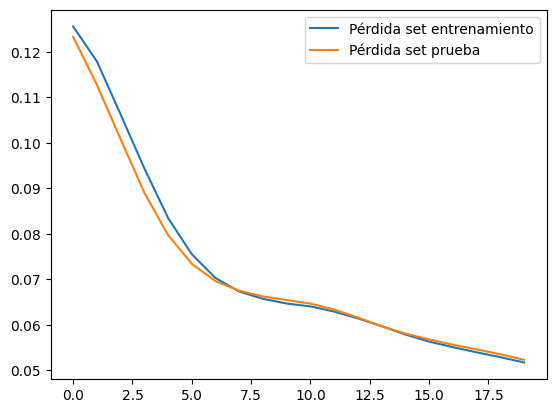

In [21]:
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.legend()

## 5- Clasificación

In [ ]:
# ¿Qué tan bien reconstruye un dato "normal" y uno anormal?
rec_normal = autoencoder(x_test_1_s).numpy()
rec_anormal = autoencoder(x_test_5_s).numpy()

dato = 5

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(x_test_1_s[dato],'b')
plt.plot(rec_normal[dato],'r')
plt.fill_between(np.arange(140), rec_normal[dato], x_test_1_s[dato], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])

plt.subplot(1,2,2)
plt.plot(x_test_5_s[dato],'b')
plt.plot(rec_anormal[dato],'r')
plt.fill_between(np.arange(140), rec_anormal[dato], x_test_5_s[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

In [ ]:
# Normal

print("mae de una muestra normal: ", keras.losses.mean_absolute_error(x_test_1_s[dato], rec_normal[dato]).numpy())
print("mae de una muestra anormal: ", keras.losses.mean_absolute_error(x_test_5_s[dato], rec_anormal[dato]).numpy())


In [ ]:
# Distribuciones de los errores de construcción
# para cada categoría

import tensorflow as tf

rec_1 = autoencoder.predict(x_test_1_s)
rec_2 = autoencoder.predict(x_test_2_s)
rec_3 = autoencoder.predict(x_test_3_s)
rec_4 = autoencoder.predict(x_test_4_s)
rec_5 = autoencoder.predict(x_test_5_s)

loss_1 = keras.losses.mean_absolute_error(rec_1, x_test_1_s)
loss_2 = keras.losses.mean_absolute_error(rec_2, x_test_2_s)
loss_3 = keras.losses.mean_absolute_error(rec_3, x_test_3_s)
loss_4 = keras.losses.mean_absolute_error(rec_4, x_test_4_s)
loss_5 = keras.losses.mean_absolute_error(rec_5, x_test_5_s)


plt.figure(figsize=(15,8))
plt.hist(loss_1[None,:], bins=100, alpha=0.75, label='normales (1)', color='blue')
plt.hist(loss_2[None,:], bins=100, alpha=0.75, color='#ff521b', label='anormales (2)')
plt.hist(loss_3[None,:], bins=100, alpha=0.75, color='#020122', label='anormales (3)')
plt.hist(loss_4[None,:], bins=100, alpha=0.75, color='#eefc57', label='anormales (4)')
plt.hist(loss_5[None,:], bins=100, alpha=0.75, color='r', label='anormales (5)')
plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')
# plt.vlines(0.08,0,70,'k')
umbral = np.mean(loss_1) + np.std(loss_1)

# Linea vertical
plt.vlines(0.03,0,70,'k')



In [ ]:
umbral = np.mean(loss_1) + np.std(loss_1)
print("Umbral: ", umbral)

### 5.1. Sensitividad y especificidad

- Verdaderos positivos (TP): anormales que han sido correctamente clasificados como anormales
- Falsos negativos (FN): anormales que han sido clasificados erróneamente como normales
- Verdaderos negativos (TN): normales que han sido correctamente clasificados como normales
- Falsos positivos (FP): normales que han sido clasificados erróneamente como anormales

La **sensitividad** mide la proporción de anormales que fueron detectados correctamente como anormales. Una sensitividad del 100% detectará a todos los pacientes enfermos:

$sensitividad = \frac{TP}{TP+FN}$

La **especificidad** mide la proporción de normales que fueron detectados correctamente como normales. Una especificidad del 100% detectará a todos los pacientes sanos:

$especificidad = \frac{TN}{TN+FP}$

In [ ]:
# Calcular predicciones individuales
def predecir(modelo, datos, umbral):
    reconstrucciones = modelo(datos)
    perdida = keras.losses.mean_absolute_error(reconstrucciones, datos).numpy()
    return perdida < umbral

def calcular_sensitividad(prediccion, titulo):
    TP = np.count_nonzero(~prediccion)
    FN = np.count_nonzero(prediccion)
    sen = 100*(TP/(TP+FN))

    print(titulo + ': {:.1f}%'.format(sen))

def calcular_especificidad(prediccion, titulo):
    TN = np.count_nonzero(prediccion)
    FP = np.count_nonzero(~prediccion)
    esp = 100*(TN/(TN+FP))

    print(titulo + ': {:.1f}%'.format(esp))
    return esp

In [ ]:
umbral = np.mean(loss_1) + np.std(loss_1)
umbral = 0.03


# Diferencia entre especificidad y sensibilidad
# Dónde pondrías el umbral en el caso de la primera ola de la pandemia?
# Y en el caso de una detección de problemas cardiacos en un apple watch?

# Predicciones
pred_1 = predecir(autoencoder, x_test_1_s, umbral)
pred_2 = predecir(autoencoder, x_test_2_s, umbral)
pred_3 = predecir(autoencoder, x_test_3_s, umbral)
pred_4 = predecir(autoencoder, x_test_4_s, umbral)
pred_5 = predecir(autoencoder, x_test_5_s, umbral)

# Pred1: especificidad
esp_1 = calcular_especificidad(pred_1,'Especificidad (cat. 1, normales)')

# Pred 2 a 5: sensitividad
sen_2 = calcular_sensitividad(pred_2,'Sensitividad (cat. 2, anormales)')
sen_3 = calcular_sensitividad(pred_3,'Sensitividad (cat. 3, anormales)')
sen_4 = calcular_sensitividad(pred_4,'Sensitividad (cat. 4, anormales)')
sen_5 = calcular_sensitividad(pred_3,'Sensitividad (cat. 5, anormales)')